# Game sales analysis
### Author: Xia Cui 

### Introduction 

This report presents the analysis of the video games sales data from the online store Ice, spanning over 30 years from 1980 to 2016. 

The dataset contains information of the games' platform and genre, the year they were released, their sales in three regions, North America, Europe, and Japan, expert and user review scores, and their ESRB (Entertainment Software Rating Board) rating. 

The goal of the analysis is to identify patterns that determine whether a game succeeds or not, which will then allow the store owners to spot potential sales winners and plan advertising campaigns. 

The report first shows the steps followed to prepare the data for analysis, then the exploratory data analysis addressing key questions including:

- the pattern in releasing games;
- how sales varied across platforms and how that changes over time;
- how user and professional reviews affect sales; 
- how sales of same games varied across platforms; and 
- how genres affected sales. 

Following the above analysis, a user profile will be created for each of the three regions. We will take a look at the top five platforms and genres for each region, and how ESRB ratings affect sales in individual regions. 

Finally, we will test 2 hypotheses: 
- average user ratings of the Xbox One and PC platforms are the same.
- average user ratings for the Action and Sports genres are different.

What follows is the table of content for easy navigation of the report. 


### Table of content 
#### [Part 1: Data importing](#importing)  
#### [Part 2: Data preprocessing](#preprocessing)  
#### [Part 3: Data transformation](#transformation)  
#### [Part 4: Exploratory data analysis](#eda)  
#### [Part 5: Games and regions](#region)
#### [Part 6: Hypothesis testing](#test)
#### [Part 7: Findings and conclusions](#conclusion)  

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st
from IPython.display import display
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Part 1: Data importing

<a id="importing"></a>

In [2]:
games = pd.read_csv("https://code.s3.yandex.net/datasets/games.csv")
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Let's take a look at the general information of the dataset. 

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
NA_sales           float64
EU_sales           float64
JP_sales           float64
Other_sales        float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

For columns that have 'object' datatypes, let's check their values, and unnecessary white spaces. 

**Checking the string columns**

In [5]:
games['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [6]:
games['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [7]:
games['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

The above three columns look fine. Now let's check the *Name* column. 

In [8]:
games['Name'].str.isspace().sum()

0

In [9]:
games['Name'].str.startswith(" ").sum()

6

In [10]:
games['Name'].str.endswith(" ").sum()

23

There are six that start with empty space, and 23 that end with empty space. This will need to be addressed in the data preprocessing later. 

Among the columns, *User_score* is supposed to be float, but shown as object. Let's take a closer look. 

In [11]:
games['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
2.3       2
0.7       2
0.5       2
0         1
9.7       1
Name: User_Score, Length: 96, dtype: int64

Now we know the reason: there is a tdb value among the numbers. This refers to 'to be determined'. We will need to address this matter later as well. 

**Checking the numeric columns**

After checking on the columns of object datatype, let's look at the numeric columns. 

In [12]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


A quick look at the summary statitics of the numeric columns shows that the sales values tend to be heavily right skewed, containing outliers on the high value end. We will keep this in mind for now. 

**Checking null values**

In [13]:
games.isnull().sum()/len(games)

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

As shown, columns that are most impacted by null values are Critic_Score, User_Score, and Rating. We will address this in the next section. 

### Part 1 Summary 

A closer examination of the dataset reveals the following issues to be addressed: 

- there are missing values in 6 columns, and the percentage for 3 of them is quite high,around 50%. 
- column names are a mix of upper and lower cases, so are the values in the dataset. They will need to be changed to all lower case. 
- User_Score has *tbd* in its values and therefore is shown as 'object' datatype. We will change the column to be float datatype. 
- there are white spaces at the start and end of the values in column 'Name'. We will get rid out these. 

In the section that follows, we will address the above issues.

### Part 2: Data preprocessing 

<a id="preprocessing"></a>

**2.1 Changing the columns and values to lower case and removing white space**

In [14]:
games.columns = games.columns.str.lower()

In [15]:
games['genre'] = games['genre'].str.lower()
games['platform'] = games['platform'].str.lower()
games['name'] = games['name'].str.lower()

In [16]:
games['name'] = games['name'].str.strip()

Now let's check.

In [17]:
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [18]:
games['name'].str.startswith(" ").sum()

0

In [19]:
games['name'].str.endswith(" ").sum()

0

**2.2 Resolving missing values**

In [20]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

**Missing values in 'name'column**

Let's take a look at the na values in name.

In [21]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


The entries that have NaN values in name also happen to have NaN in genre. Let's see if we can find information about game name from 'year_of_release" and 'platform" columns. 

In [22]:
games[(games['year_of_release'] == 1993) & (games['platform'] == "gen")].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
7885,shining force ii,gen,1993.0,strategy,0.00,0.00,0.19,0.00,NaN,NaN,NaN
8893,super street fighter ii,gen,1993.0,fighting,0.00,0.00,0.15,0.00,NaN,NaN,NaN
11986,ecco: the tides of time,gen,1993.0,adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12098,street fighter ii': special champion edition (...,gen,1993.0,action,0.00,0.00,0.07,0.00,NaN,NaN,NaN


It seems that information of the year and platform doesn't help with filling the na values in name or genre. These two rows will be dropped. 

In [23]:
games = games[games['name'].notna()]

In [24]:
games['name'].isna().sum()

0

In [25]:
games[games['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,NaN,sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,fifa soccer 2004,ps2,NaN,sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,lego batman: the videogame,wii,NaN,action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe smackdown vs. raw 2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


**Missing values in 'year_of_release' column**

In [26]:
games['year_of_release'].isna().sum()

269

In [27]:
games[games['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,NaN,sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,fifa soccer 2004,ps2,NaN,sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,lego batman: the videogame,wii,NaN,action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe smackdown vs. raw 2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


We will take a look at the first game in the list above to see if we can get some information about the release year from other columns. 

In [28]:
games[games['name'] == "madden nfl 2004"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,NaN,sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,madden nfl 2004,xb,2003.0,sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,madden nfl 2004,gc,2003.0,sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,madden nfl 2004,gba,2003.0,sports,0.22,0.08,0.00,0.01,70.0,6.6,E


In [29]:
games['year_of_release'] = games.groupby('name')['year_of_release'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

In [30]:
games['year_of_release'].isna().sum()

146

The above shows that we still have 146 missing years because these games appear only once and therefore doesn't have any release year information. This represents less than 1% of the total data. Because 'year_of_release' is an important parameter later when we look at the trend in game polularity, we will drop these 146 rows from the dataset. 

In [31]:
games = games[games['year_of_release'].notna()]

In [32]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8492
user_score         6633
rating             6699
dtype: int64

**Missing values in the rest three columns**

Before we move on to deal with the missing values in the last three columns, let's change the data type of the 'user_score' column. 

In [33]:
games['user_score'].dtypes

dtype('O')

In [34]:
games[games['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,zumba fitness,wii,2010.0,sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,namco museum: 50th anniversary,ps2,2005.0,misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,zumba fitness 2,wii,2011.0,sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,udraw studio,wii,2010.0,misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,just dance kids,wii,2010.0,misc,1.52,0.54,0.0,0.18,NaN,tbd,E


It doesn't look like that we can obtain useful information from other columns to fill the tbd value. Therefore, we will change the column to numeric data type and use 'coerce' for the errors parameter. This will force the tbd values to NaN. 

In [35]:
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'coerce')

In [36]:
games['user_score'].dtypes

dtype('float64')

While we are here, let's also change the 'year_of_release' to integer datatype to get rid of the 0 after the decimal point. 

In [37]:
games['year_of_release'] = games['year_of_release'].astype('int')

In [38]:
games['user_score'].isna().sum()

9027

Now 'user_score' column has more missing values. 

A glimpse of the first few rows with missing 'user_score' values shows the possibility that rows that miss 'user_score' might also miss the 'critic_score' and 'rating' values. Let's check. 

In [39]:
len(games[(games['critic_score'].isna()) & (games['user_score'].isna()) &
          (games['rating'].isna())])

6601

Indeed, there are 6601 rows that have missing values in all three columns. It's a rather significant number because it represents almost 40% of the total dataset.  

What's best would be to fill up the missing values with the median value of the game with the same name. There will still be quite a lot of missing values left unfilled though because as we know already, many game names appear only once in the dataset. Let's go ahead and do this. 

In [40]:
games['critic_score'] = games.groupby('name')['critic_score'].transform(
    lambda x: x.fillna(x.median()))
games['user_score'] = games.groupby('name')['user_score'].transform(
    lambda x: x.fillna(x.median()))
games['rating'] = games.groupby('name')['rating'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

In [41]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       7532
user_score         7928
rating             6262
dtype: int64

We managed to have filled a very small portion of the missing values in the last three columns. Given that what's left represents a significant part of the data, we will keep them as they are now, but bear in mind in later calculations that there are still missing values in these three columns. 

### Part 2 summary 

In this section, we've changed the column names and string values in the dataset all in lower case, removed the white space at the beginning and end of the 'name' column, filled up the missing values in the dataset to the best we can, and changed the columns to their correct datatype. Before we proceed to exploratory data analysis, we will add a 'total_sales' column next. 

### Part 3: Data transformation 

<a id="transformation"></a>

We will need a 'total_sales' column when we later look at the sales across platform. Let's do that now. 

In [42]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games[
    'jp_sales'] + games['other_sales']

In [43]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Now the dataset is ready to be analysed!

### Part 4: Exploratory data analysis 

<a id="eda"></a>

**4.1 Games released by year**

First, let's find out if there is any pattern in game release year by year. 

In [44]:
len(games['year_of_release'].unique())

37

In [45]:
games.groupby('year_of_release')['name'].count().sort_values(ascending=False).head()

year_of_release
2008    1441
2009    1430
2010    1270
2007    1202
2011    1153
Name: name, dtype: int64

As shown above, the dataset contains games released over 37 years, and the top five years for game release are 2008, 2009, 2010, 2007, and 2011. 

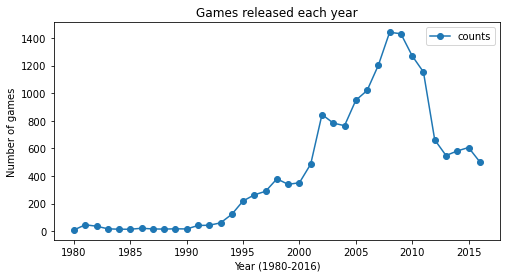

In [46]:
games['year_of_release'].value_counts().rename_axis(
    'year_of_release').reset_index(name='counts').sort_values(
    'year_of_release').plot(x="year_of_release", y='counts', style = 'o-', figsize = (8,4))
plt.title('Games released each year')
plt.ylabel("Number of games")
plt.xlabel("Year (1980-2016)")
plt.show()

It's very interesting to see that the number of games released remained very low until 1993, after which we see overall a steady increase, despite some fluctuation around 2000 and 2005. The number reached its peak at 2008 and 2009, followed by a quite drastic decline in the years that follow. By the time it was 2015, the number has dropped to less than half of its peak. 

Without any further information, we might conclude that video games were at their peak in terms of game release between 2007 to 2011. It could be that games in recently years are more complex and take longer time to develop. For the purpose of this report, we will leave it here. 

**4.2 Sales across platforms**

In [47]:
len(games['platform'].unique())

31

In [48]:
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(6)

platform
ps2     1247.16
x360     966.61
ps3      935.19
wii      903.31
ds       804.28
ps       727.58
Name: total_sales, dtype: float64

There are a total of 31 platforms, and those that generated the highest total sales are above. Let's pick these 6 and take a look at how their sales might have changed over the years. 

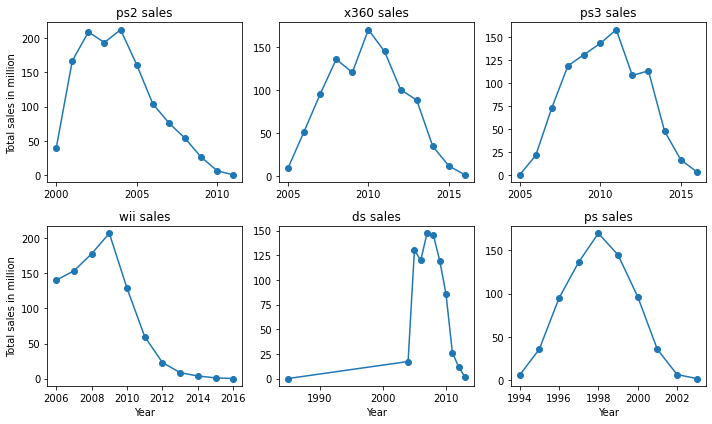

In [49]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))

games[games['platform'] == "ps2"].groupby(
    'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("Total sales in million")
ax1.set_title("ps2 sales")
ax1.locator_params(integer=True)

games[games['platform'] == "x360"].groupby(
    'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax2)
ax2.set_xlabel("")
ax2.set_title("x360 sales")
ax2.locator_params(integer=True)

games[games['platform'] == "ps3"].groupby(
    'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax3)
ax3.set_xlabel("")
ax3.set_title("ps3 sales")
ax3.locator_params(integer=True)

games[games['platform'] == "wii"].groupby(
    'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax4)
ax4.set_xlabel("Year")
ax4.set_ylabel("Total sales in million")
ax4.set_title("wii sales")
ax4.locator_params(integer=True)

games[games['platform'] == "ds"].groupby(
    'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax5)
ax5.set_xlabel("Year")
ax5.set_title("ds sales")
ax5.locator_params(integer=True)

games[games['platform'] == "ps"].groupby(
    'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax6)
ax6.set_xlabel("Year")
ax6.set_title("ps sales")
ax6.locator_params(integer=True)

plt.tight_layout()

Although sales of all the above 6 platforms dropped significantly in the end, 'ps2' and 'wii' in particular seem to have dropped to almost zero. Let's check. 

In [50]:
games[games['platform'] == "ps2"].groupby(
    'year_of_release')['total_sales'].sum().tail(1)

year_of_release
2011    0.45
Name: total_sales, dtype: float64

In [51]:
games[games['platform'] == "wii"].groupby(
    'year_of_release')['total_sales'].sum().tail(1)

year_of_release
2016    0.18
Name: total_sales, dtype: float64

We plotted the total sales of the 6 most profitable platforms, all six, when at the peak of their game, had total sales over 150 million dolloars, among whom ps2 reached over 200 million dollars. However, within the span of approximately ten years since they started become popular, their sales had dropped significantly. This is especially the case for ps2 and wii, whose sales dropped to 0.45 million (2011) and 0.18 million (2018) respectively. 


Based on the information above, it seems that a platform's lifespan is around 10 years between when it started to trend and when it started to disappear from the market. The popularity peaked after approximately 4 or 5 years. 

For ps2, for example, its sales started to increase in 2000, reached its peak at 2004, and by 2011, its sales dropped to 0.45 million. There is not sales figure following that, which leads us to assume that it was out of the market. 

For ds, although the games on this platform started to sell as early as 1985, the sales didn't pick up until 2004. It then quickly reached its sales peak in 2007 and 2008, followed by a drastic decline, dropping to 1.54 million in 2013. 

It should also be noted though, the number of games released each year has been declining since 2010. This could potentially be partly blamed for the overall deseasing global sales. 

Therefore, given our goal is to predict what would be trending in 2017, we probably don't need data older than 10 years.

Further more, it says in the data description that data in 2016 might not be complete. Incomplete yearly sales figure still taken as a year could be very misleading. To slice the data, we will still include the 2016 data but bear in mind that it's not complete. Let's go ahead and slice the 2007 to 2016 data. 

**4.3 Slicing the data for further analysis**

In [52]:
games_new = games[(games['year_of_release'] >= 2007)
                  & (games['year_of_release'] <= 2016)]

In [53]:
games_new.shape

(9395, 12)

In [54]:
games_new.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       4254
user_score         4320
rating             3164
total_sales           0
dtype: int64

The new game dataset contains 9395 rows, a significant proportion of which have missing values in the 'critic_score', 'user_score', and 'rating' columns. This is something we need to keep in mind when doing calculations and hypothesis testing later with values from these columns. 

**4.4 Top selling and potentially profitable platforms**

First, we will have a look at the total sales generated from each platform. 

In [55]:
games_new.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
ps3     913.56
x360    905.60
wii     763.12
ds      537.04
ps4     314.14
3ds     258.51
psp     186.39
pc      163.61
ps2     163.44
xone    159.32
wiiu     82.19
psv      53.81
gba       3.40
xb        0.73
gc        0.27
dc        0.06
Name: total_sales, dtype: float64

What the figures above can tell us is that the top 5 selling platforms in the last decade are ps3, x360, wii, ds, and ps4. However, they don't really tell which platforms might be on the decline, and which ones might be on the rise. To obtain that information, let's plot the sales from each platform. 

Before we plot the data, we can notice that the last 4 have very small sales. If they just started, for example, in 2014 or 2015, then it is possible that they can become popular. However, if they are no longer in the market, we don't need them for the follow up analysis. Let's check. 

In [56]:
games_new[games_new['platform'] == 'gba']['year_of_release'].unique()

array([2007])

In [57]:
games_new[games_new['platform'] == 'xb']['year_of_release'].unique()

array([2007, 2008])

In [58]:
games_new[games_new['platform'] == 'gc']['year_of_release'].unique()

array([2007])

In [59]:
games_new[games_new['platform'] == 'dc']['year_of_release'].unique()

array([2008, 2007])

Okay. We can go ahead and remove them from the data because these 4 are a quick existence and no longer in the market. 

In [60]:
platform_to_exclude = ['gba', 'xb', 'gc', 'dc']
games_new = games_new.query('platform not in @platform_to_exclude')

From previous plots, we already know ps3, ps2, x360, wii, ds have reached their peak and been declining ever since. Let's check out the other platforms in the plots below: ps4, 3ds, xone, pc, wiiu, psp, psv. Knowing the 2016 data is not complete, we will exclude the sales from 2016 for the plots below. 

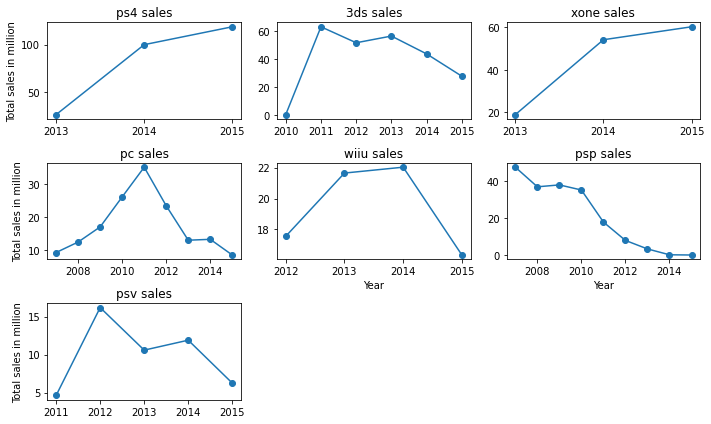

In [61]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,
                                                       3,
                                                       figsize=(10, 6),
                                                       sharex=False)

games_new[(games_new['platform'] == "ps4")
          & (games_new['year_of_release'] != 2016)].groupby(
              'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("Total sales in million")
ax1.set_title("ps4 sales")
ax1.locator_params(integer=True)

games_new[(games_new['platform'] == "3ds")
          & (games_new['year_of_release'] != 2016)].groupby(
              'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax2)
ax2.set_xlabel("")
ax2.set_title("3ds sales")
ax2.locator_params(integer=True)

games_new[(games_new['platform'] == "xone")
          & (games_new['year_of_release'] != 2016)].groupby(
              'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax3)
ax3.set_xlabel("")
ax3.set_title("xone sales")
ax3.locator_params(integer=True)

games_new[(games_new['platform'] == "pc")
          & (games_new['year_of_release'] != 2016)].groupby(
              'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax4)
ax4.set_xlabel("")
ax4.set_title("pc sales")
ax4.set_ylabel("Total sales in million")
ax4.locator_params(integer=True)

games_new[(games_new['platform'] == "wiiu")
          & (games_new['year_of_release'] != 2016)].groupby(
              'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax5)
ax5.set_xlabel("Year")
ax5.set_title("wiiu sales")
ax5.locator_params(integer=True)

games_new[(games_new['platform'] == "psp")
          & (games_new['year_of_release'] != 2016)].groupby(
              'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax6)
ax6.set_xlabel("Year")
ax6.set_title("psp sales")
ax6.locator_params(integer=True)

games_new[(games_new['platform'] == "psv")
          & (games_new['year_of_release'] != 2016)].groupby(
              'year_of_release')['total_sales'].sum().plot(style="o-", ax=ax7)
ax7.set_xlabel("")
ax7.set_title("psv sales")
ax7.set_ylabel("Total sales in million")
ax7.locator_params(integer=True)

fig.delaxes(ax8) 
fig.delaxes(ax9) 

plt.tight_layout()

Given what we know so far about the life span of a platform, two platforms, **ps4** and **xone** , which started in 2013, are most likely on the rising trend in their popularity. From previous plots, we also know that popular platforms can generate total sales up to over 150 million dollars at their peak. Therefore, **xone** in particular will be a potential platform to grow. 

Among the rest, psp started before 2007 and seemed to have already reached its peak, similar to ps3, ps2, x360, wii, and ds, which we plotted earlier. pc platform too, which started in 2007, seemed to have reached its peak in 2011 and most likely will reach the end of its life span in 2017. 

The other three platforms, **3ds**, **wiiu**, and **psv**, are relatively new (2010, 2012, 2011 respectively). They don't show as a promising trend in sales as ps4 and xone, which could be a temporary fluctuation before sale pick up, or an indication of their lack of popularity. Some further investigation might be needed before deciding whether or not they should be included in the promotion, such as critic_score and user_score. We can quickly check this. 

In [62]:
games_new.groupby('platform')[['critic_score', 'user_score'
                               ]].median().sort_values('critic_score',
                                                       ascending=False)

,critic_score,user_score
platform,,
xone,76.50,6.8
pc,76.00,7.1
ps4,74.00,7.1
wiiu,73.75,7.3
ps3,73.00,7.1
psv,71.00,7.6
x360,71.00,7.0
3ds,69.00,7.0
psp,69.00,7.3


We can see that the median critic_score and user_score of 3ds, wiiu, and psv are situated somewhat in the middle among all platforms. Therefore, also given the age of the platform, we wouldn't rule out the possibility that their sales might pick up in 2017 but will need further data and investigation to be more confident about it. For now, we will leave it as it is. 

**4.5 Global sales of games across all platforms**

First, let's take a look at the summary statistics of the game sales on all platforms. 

In [63]:
games_new.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3ds,514.0,0.502938,1.438494,0.01,0.050,0.125,0.3375,14.60
ds,1786.0,0.300694,0.767255,0.01,0.040,0.110,0.2700,15.13
pc,735.0,0.222599,0.559012,0.01,0.020,0.050,0.1800,8.01
ps2,548.0,0.298248,0.511670,0.00,0.030,0.130,0.3800,4.99
ps3,1291.0,0.707637,1.403783,0.00,0.105,0.270,0.7550,21.05
ps4,392.0,0.801378,1.609456,0.01,0.060,0.200,0.7300,14.63
psp,902.0,0.206641,0.428267,0.01,0.030,0.080,0.2100,5.49
psv,429.0,0.125431,0.212341,0.01,0.020,0.050,0.1300,1.96
wii,1253.0,0.609034,2.061234,0.01,0.090,0.190,0.4800,35.52


A browse of the figures above already shows quite some difference in global sales across all platforms. Now let's plot a series of boxplots to show the sales. Given the distributions are heavily right skewed, we will use log scale here.

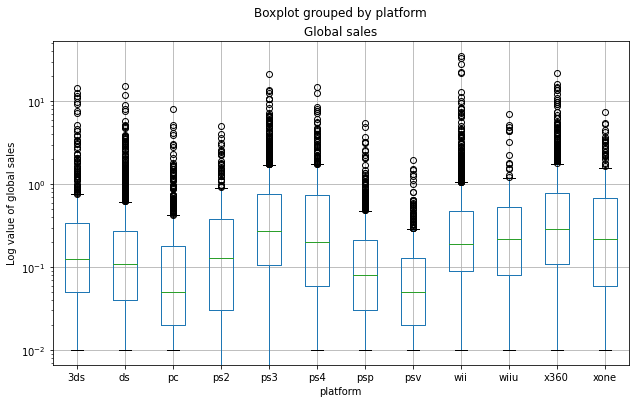

In [64]:
games_new.boxplot('total_sales', by='platform', figsize=(10, 6))
plt.yscale("log")
plt.title('Global sales')
plt.ylabel('Log value of global sales')
plt.show()

As shown in the boxplots and summary figures, sales vary a lot from platform to platform in terms of their mean, median and spread. The platform that has the higest average global sales is **ps4**, followed by **x360** and **ps3**. The platform that has the highest sales median value is **x360**, followed by **ps3**, and then **wiiu** and **xone**. 

All the sales distribution are right skewed, packed with outliers on the higher value end. 

Having said the above, we need to bear in mind that these figures can be misleading, because average or median sales only tell us how the platforms have performed in the past, yet based on our previous analysis we know that their popularity follows a pyramid shape. Another important factor is the age of the game, which doesn't show in the boxplots above. 

**4.6 Impact of reviews on sales**

Over the last decade, ps3 has generated over 900 million dollars in sales. So for this section examining the impact of reviews on sales, let's use ps3 as an example. 

Let's first build a scatter plot to show the relationship between critic_score and total_sales, as well that between user_score and total_sales. 

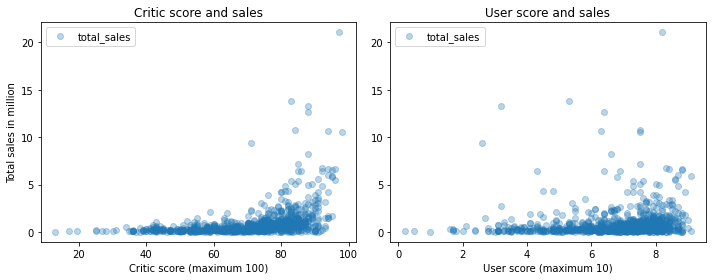

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
games_new[(games_new['platform'] == "ps3")
          & (games_new['critic_score'].notnull())].plot(x='critic_score',
                                                        y='total_sales',
                                                        style='o',
                                                        alpha=0.3,
                                                        ax=ax1)
ax1.set_title('Critic score and sales')
ax1.set_ylabel('Total sales in million')
ax1.set_xlabel('Critic score (maximum 100)')

games_new[(games_new['platform'] == "ps3")
          & (games_new['user_score'].notnull())].plot(x='user_score',
                                                      y='total_sales',
                                                      style='o',
                                                      alpha=0.3,
                                                      ax=ax2)
ax2.set_title('User score and sales')
ax2.set_xlabel('User score (maximum 10)')

plt.tight_layout()

The above scatter plot shows a somewhat positive correlation between critic score and sales, and a much weaker correlation between user score and sales. 

In [66]:
games_new.query('platform == "ps3"')[[
    'critic_score', 'user_score', 'total_sales'
]].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.553145,0.407595
user_score,0.553145,1.000000,0.127197
total_sales,0.407595,0.127197,1.000000


In the case of the ps3 platform, we can see that critic score and sales have a moderate positive correlation(0.408), whereas user score and sales have a very weak positive correlation (0.127). It is possible that users might tend to follow expert advice when purchasing games but users individual preferences and taste mght vary a lot and thus their review score of the games does not show clear correlation with game popularity.

**4.7 Sales of same games across different platforms**

Now we know ps3 is the leading platform in sales. It would be interesting to find out how the same games are performing in sales on other platforms. Let's find out. 

In [67]:
len(games_new.query('platform =="ps3"')['name'].unique())

1290

There are 1290 games on ps3 platform. Let's find out the top selling games!

In [68]:
games_new.query('platform =="ps3"').groupby(
    'name')['total_sales'].sum().sort_values(ascending=False).head()

name
grand theft auto v                21.05
call of duty: black ops ii        13.79
call of duty: modern warfare 3    13.33
call of duty: black ops           12.63
gran turismo 5                    10.70
Name: total_sales, dtype: float64

The 5 top selling games are shown above. Let's pick the first one to compare sales across platforms. 

In [69]:
games_new.query('name == "grand theft auto v"').groupby('platform')['total_sales'].sum()

platform
pc       1.17
ps3     21.05
ps4     12.62
x360    16.27
xone     5.47
Name: total_sales, dtype: float64

It's interesting to see that the same game generated very different sales from different platforms. Taking the 'grand theft auto v' game for example, ps3, ps4, and x360 generate the most sales for it, where as xone and pc, in comparision, generate quite low sales figure. 

**4.8 Sales by genre**

In the analysis in this section, we are hoping to find out games of what genres are the most profitable! 

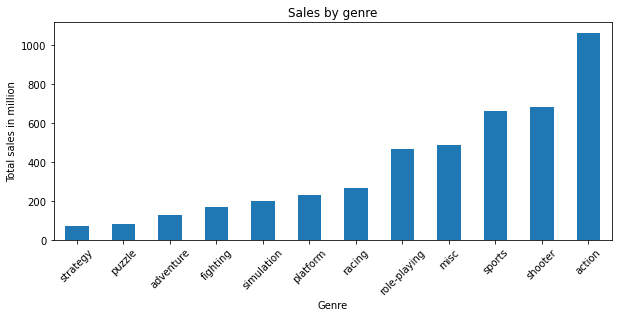

In [70]:
games_new.groupby('genre')['total_sales'].sum().sort_values().plot(
    kind='bar', title="Sales by genre", figsize=(10, 4))
plt.xticks(rotation=45)
plt.xlabel("Genre")
plt.ylabel('Total sales in million')
plt.show()

As shown above in the bar plot, the most profitable genre in video games seems to be **action**, followed by **shooter**, and **sports**. The least profitable are **strategy** and **puzzle**.                                                            

However, we need to keep in mind that the sales calculated in the above graph are global sales. We might expect for different regions the popularity of the genres might differ. This is what we are going to look at next in the next section. 

### Part 4 summary 

In this section of exploratory data analysis, we found out about the trend in the number of games released each year, showing its peak around 2009 and 2010. It would be interesting to also find out why the number is declining, but that is beyond the scope of this report. 


We also came to learn what game platforms were leading in sales, and how that might change over the years. Given what seems to be the typical life span of platforms, 10 years, we further subset the data to include only those in the last 10 years for further analysis. 

The analysis of the reduced dataset reveals two strong candidates for potential sales growth, **ps4** and **xone**, which should be the focus for promotion by the store. 

It is also interesting to know that the expert reviews did show a mild positive correlation with sales, and the sales of the same game can vary greatly across platforms. 

Finally, we found out action, shooter and sports genres are the most profitable. however, is this true across the three regions? This is our focus of analysis next. 

### Part 5: Games and regions

<a id="region"></a>

**5.1 Top 5 platforms in each region**

First, let's build a user profile by region to find out the market share by platform. 

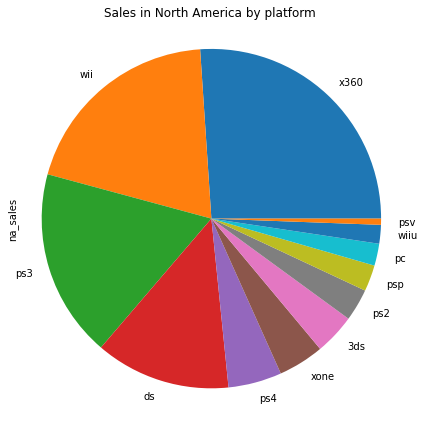

In [71]:
games_new.groupby('platform')['na_sales'].sum().sort_values(
    ascending=False).plot(kind='pie', figsize=(6, 6))
plt.axis('equal')
plt.title('Sales in North America by platform')
plt.tight_layout()

The top five platforms in North America, as shown above, are x360, wii, ps3, ds, and ps4, occupying over 3 quarters of the market! 

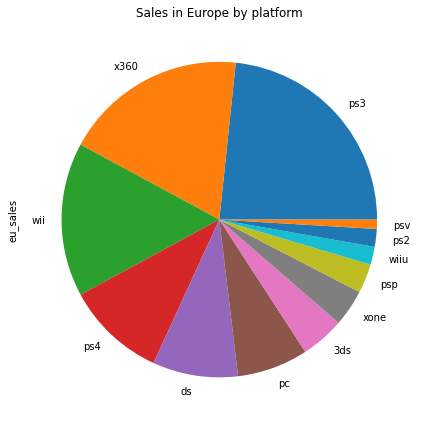

In [72]:
games_new.groupby('platform')['eu_sales'].sum().sort_values(
    ascending=False).plot(kind='pie', figsize=(6, 6))
plt.title('Sales in Europe by platform')
plt.tight_layout()

The top five platforms in Europe, as shown above, are ps3, x360, wii, ps4, and ds, also representing over 3 quarters of the market share. 

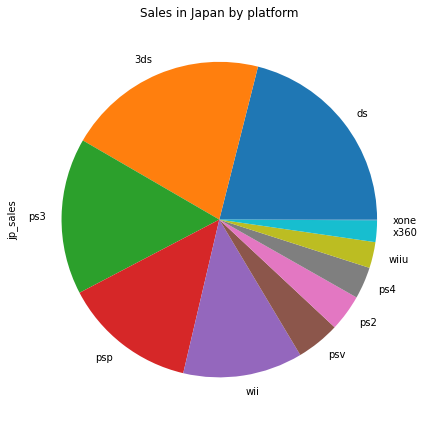

In [73]:
games_new.groupby('platform')['jp_sales'].sum().sort_values(
    ascending=False).plot(kind='pie', figsize=(6, 6))
plt.title('Sales in Japan by platform')
plt.tight_layout()

The top five platforms in Japan, as shown above, are ds, 3ds, ps3, psp, and wii. 

It's intereting to see that while the top 5 platforms are the same for North America and Europe, only differing in order, the japanese market is quite different, with **ds** platform leading the sales. **3ds**, which didn't make to the top 5 for the other two regions, came in second in sales. 

It's also worth noting that while ps4 is already leading the market share in Japan, it is still a minor player in the North American and European market. Xone at the moment takes a very small market portion across the three regions. If our prediction is right previously, we are likely to see these two platforms grow significantly in the next few years. 

**5.2 Top 5 genres in each region**

Let's have a change and use numbers instead of charts for this analysis. We will calcualte the percentage of market share for the top five genres in each region. 

In [74]:
games_new.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(
) / games_new.groupby('genre')['na_sales'].sum().sum()

genre
action          0.233615
shooter         0.164622
sports          0.152094
misc            0.121481
role-playing    0.082182
Name: na_sales, dtype: float64

In [75]:
games_new.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(
) / games_new.groupby('genre')['eu_sales'].sum().sum()

genre
action     0.247630
shooter    0.168298
sports     0.154259
misc       0.092884
racing     0.076090
Name: eu_sales, dtype: float64

Above shows a similar pattern in North America and Europe, action as a genre is leading the market, followed by shooter and sports. This is consistent with our analysis of the genre popularity overall earlier. How about Japan? Let's take a look. 

In [76]:
games_new.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(
) / games_new.groupby('genre')['jp_sales'].sum().sum()

genre
role-playing    0.308038
action          0.196973
misc            0.101882
sports          0.082921
adventure       0.054960
Name: jp_sales, dtype: float64

It's interesting, isn't it? Role playing is the biggest player in the Japanese market, representing over 30% of the market share, higher than the number 1 genre in both North America and Europe! Action, sports, and misc also make to the top 5, similar to the other two regions. 

**5.3 ESRB ratings and sales in each region**

Does ESRB ratings affect sales? How does that differ across regions. Let's find out. 

In [77]:
games_new.groupby('rating')['na_sales'].sum().sort_values(
    ascending=False).head() / games_new.groupby(
        'rating')['na_sales'].sum().sum()

rating
E       0.351795
M       0.292905
T       0.197880
E10+    0.156467
EC      0.000953
Name: na_sales, dtype: float64

In [78]:
games_new.groupby('rating')['eu_sales'].sum().sort_values(
    ascending=False).head() / games_new.groupby(
        'rating')['eu_sales'].sum().sum()

rating
M       0.335954
E       0.332799
T       0.187140
E10+    0.144082
RP      0.000025
Name: eu_sales, dtype: float64

In [79]:
games_new.groupby('rating')['jp_sales'].sum().sort_values(
    ascending=False).head() / games_new.groupby(
        'rating')['jp_sales'].sum().sum()

rating
E       0.382107
T       0.319962
M       0.170365
E10+    0.127566
RP      0.000000
Name: jp_sales, dtype: float64

In ESRB rating system, M refers to mature audience, E refers to, T refers to teenager. While in North America and Europe, M and E top the sales, in Japan, E and T are leading in sales. 

In conclusion, North American and European market show great similarity in terms of what platforms and genres are popular, as well as what rating games are most profitable. The japanese market is quite different, showing a different preference in all three aspects. This is interesting information when it comes to promoting games in different regions. 

### Part 6: Hypothesis testing

<a id="test"></a>

In this section, we will test the following two hypotheses:

- Average user ratings of the Xbox One and PC platforms are the same.
- Average user ratings for the Action and Sports genres are different.

Both are two sided test, and the alpha threshold value is set as 0.05, following what is typically used in hypothesis testing. 

**6.1 Hypothesis test 1**

The null hypothesis for this test is that the average user score of the xone and pc platforms are the same.

The alternative hypothesis is that they are different. We will use T test. 

First, let's creat two datasets, one for Xbox One, and the other for PC platform.

In [80]:
xone = games_new.query("platform == 'xone'")
pc = games_new.query("platform == 'pc'")

It needs to be noted user rating (user_score) has missing values. Let's check how many are they. 

In [81]:
xone['user_score'].isna().sum()/len(xone)

0.1659919028340081

In [82]:
pc['user_score'].isna().sum()/len(pc)

0.19591836734693877

We will need to exclude those missing values when performing the hypothesis testing. Let's create two series containing only user_score values for each platform.

In [83]:
pc_user_score = pc[pc['user_score'].notna()]['user_score']
xone_user_score = xone[xone['user_score'].notna()]['user_score']

Next, let's look at the summary statistics of the two sets. 

In [84]:
pc_user_score.describe()

count    591.000000
mean       6.768020
std        1.526356
min        1.400000
25%        5.900000
50%        7.100000
75%        8.000000
max        9.300000
Name: user_score, dtype: float64

In [85]:
xone_user_score.describe()

count    206.000000
mean       6.617233
std        1.376114
min        1.600000
25%        5.825000
50%        6.800000
75%        7.700000
max        9.200000
Name: user_score, dtype: float64

Before we perform the t test to compare the means of the user_score between two platforms, we need to find out if they are from a normal distribution. 

In [86]:
st.shapiro(pc_user_score)

ShapiroResult(statistic=0.9241381287574768, pvalue=1.0987273316930376e-16)

In [87]:
st.shapiro(xone_user_score)

ShapiroResult(statistic=0.950167179107666, pvalue=1.4204860008248943e-06)

Both have pvalue a lot smaller than 0.05, which indicates that the values are not from a normal distribution. Therefore, to find out if the two sets of score have similar variance, we will use the levene test. 

In [88]:
st.levene(xone_user_score, pc_user_score, center = 'mean')

LeveneResult(statistic=4.347459564581033, pvalue=0.03738270157950809)

Pvalue from teh Levene test is small than 0.05, which indicates that the two sets of values have different variance. We will set the equal_var as False for the t test below. 

In [89]:
st.ttest_ind(xone_user_score, pc_user_score, equal_var=False).pvalue

0.18904387274578785

Pvalue from the T test is higher than our significance threshold value, 0.05, therefore we can not reject the null hypothesis, that the average ratings of the xone and pc platform are the same. 

**6.2 Hypothesis test 2**

For this test, our null hypothesis is: average user ratings for the Action and Sports genres are the same. 

Our alternative hypothesis is, they are different. 

First, let's subset the data. 

In [90]:
action = games_new.query("genre == 'action'")
action_user_score = action[action['user_score'].notna()]['user_score']

sports = games_new.query("genre == 'sports'")
sports_user_score = sports[sports['user_score'].notna()]['user_score']

In [91]:
action_user_score.describe()

count    1430.000000
mean        6.825839
std         1.337791
min         1.600000
25%         6.100000
50%         7.100000
75%         7.800000
max         9.500000
Name: user_score, dtype: float64

In [92]:
sports_user_score.describe()

count    712.000000
mean       6.289115
std        1.647193
min        0.200000
25%        5.400000
50%        6.600000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

First, we need to do a shapiro test to see if the two sets of scores are from a normal distribution. 

In [93]:
st.shapiro(action_user_score)

ShapiroResult(statistic=0.9374015927314758, pvalue=4.50408337989351e-24)

In [94]:
st.shapiro(sports_user_score)

ShapiroResult(statistic=0.9434061646461487, pvalue=7.677331933367607e-16)

Neither is from a normal distribution. So we will use levene test again to check on variance.

In [95]:
st.levene(action_user_score, sports_user_score, center = 'mean')

LeveneResult(statistic=39.50739138137812, pvalue=3.9488164561871013e-10)

The test above results in a very small pvalue, therefore we will set equal_var as False.

In [96]:
st.ttest_ind(action_user_score, sports_user_score, equal_var=False).pvalue

9.04313973035504e-14

The pvalue from the test is a lot smaller than alpha, 0.05, therefore we can reject the null hypothesis and conclude that the average user ratings for action and sports genre games are different! 

In conclusion, using alpha 0.05, we can conclude that average user ratings of the Xbox One and PC platforms are the same, but average user ratings for the Action and Sports genres are different.

### Part 7: Findings and conclusions 

<a id="conclusion"></a>

This report has presented the analysis of the video games sales data from the online store Ice, from 1980 to 2016. 

The goal of the analysis was to identify patterns that determine a game's success,which will then allow the store owners to spot potential sales winners and plan advertising campaigns.

We found out that the typical lifespan for a game platform was approximately 10 years. During this time, the platform would reach the peak of its popularity, as measured in sales, when it was 4 or 5 years old, after which the sales started to decline, until finally the platform was replaced by newer platforms and disappearred from the market. 

Based on this information, the store owner should focus the promotion on platforms that are perhaps 3 or 4 years old and still showing a rising trend in sales. Our study shows that **ps4** and **xone** are good candidate for market promotion. 

However, knowing which platforms to promote is only half of the game. The owner should also try to get more positive expert reviews for the platforms and games they are promoting because our analysis shows a moderate positive correlation between expert review and sales. 

Furthermore, store owner should also be aware of the region differences in their preference in platform, genre, and ESRB ratings. The Japanese market in particular shows a different preference from the North American and European market. The marketing team will need to adjust their focus and strategy when promoting video games in different regions. For example, games of role playing genre with E or T ratings might be a safe bet for the Japanese market, whereas action games with E or M ratings will generate better sales in the North American and European market. 